# IMAGE BLENDING

Since the deep fake model input requires images of 255 by 255 pixels, I was constrained to using a screenshot of Mona Lisa's head of those sizes. The idea was to then plop the deep fake head on top of a full portrait of the Mona Lisa.

Since the deep fakes generated by the first order model don't quite stitch together well when superimposed on top of the image of the actual Mona Lisa painting (it's very obvious it's a picture on top of a painting), we can apply a sigmoid to weight the pixel values to adjust the deep fakes; the outer edges of the deep fakes will contain pixel values that match the painting, and towards the center, use only pixels of the deep fake.

**Note**: this notebook is very messy. Don't trust the execution order!

In [11]:
from matplotlib import pyplot as plt
import cv2
from PIL import Image

import numpy as np
import math

from skimage.transform import resize

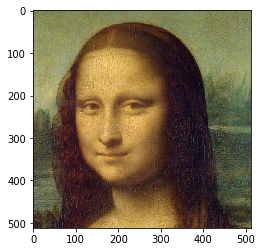

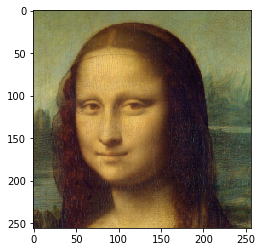

In [12]:
image = plt.imread("data/standardized_ss.png")
image_resized = resize(image, (256, 256))

plt.imshow(image)
plt.show()
plt.imshow(image_resized)
plt.show()


In [13]:
# import imageio
from numpy import load
# predictions_video = np.array(imageio.mimread("predictions_with_new_image.mp4", memtest=False)
predictions_video = load("data/predictions_data_standardized_ss.npy")

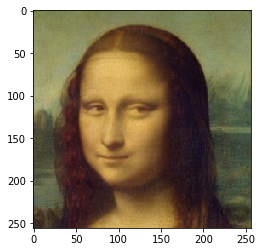

In [14]:
plt.imshow(predictions_video[450])

In [15]:
plt.imsave("test_1.png", predictions_video[450])

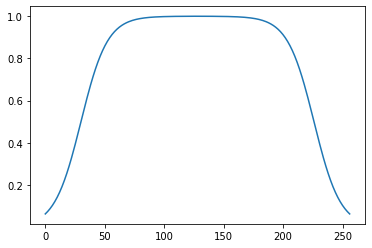

In [16]:
slope = 0.6
inflection = 0.3


slope = 0.09
inflection = 30
# https://www.desmos.com/calculator/rna4aqta0c

midpoint = 256 // 2

def mirrored_sigmoid(x):
    if x <= midpoint:
        return 1 / (1 + math.exp(-slope * (x - inflection)))
    else:
        return 1 / (1 + math.exp(-slope * (2 * midpoint - x - inflection)))
    
xs = np.linspace(0, 256, 256)
ys = [mirrored_sigmoid(x) for x in xs]
plt.plot(xs, ys)

In [17]:
predictions_video[0]

array([[[0.45578212, 0.47391647, 0.30897424],
        [0.44223475, 0.45856398, 0.2842665 ],
        [0.43446177, 0.45074743, 0.27444595],
        ...,
        [0.45126128, 0.47437292, 0.3175879 ],
        [0.45612788, 0.46172324, 0.31318614],
        [0.47336718, 0.45368576, 0.34763515]],

       [[0.47033134, 0.4895273 , 0.31054908],
        [0.46630466, 0.48546517, 0.3066376 ],
        [0.45726383, 0.47312552, 0.30105665],
        ...,
        [0.4661243 , 0.49155912, 0.33560285],
        [0.4547878 , 0.4756724 , 0.31621024],
        [0.47468218, 0.4653995 , 0.33809593]],

       [[0.46722385, 0.47753483, 0.30243477],
        [0.47443557, 0.48140848, 0.31693074],
        [0.47311008, 0.4722801 , 0.31577402],
        ...,
        [0.48871368, 0.49535787, 0.3570315 ],
        [0.44544384, 0.4667294 , 0.31253076],
        [0.46145374, 0.4480999 , 0.31084287]],

       ...,

       [[0.20535684, 0.16184041, 0.13990036],
        [0.21768454, 0.15960425, 0.15245318],
        [0.23054707, 0

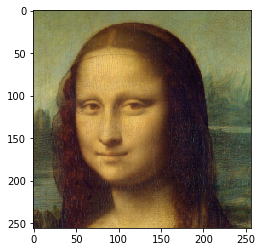

In [18]:
plt.imshow(image_resized)
plt.imsave("ss_test.png", image_resized)

In [19]:
plt.imsave("ss_predictions_test.png", predictions_video[450])

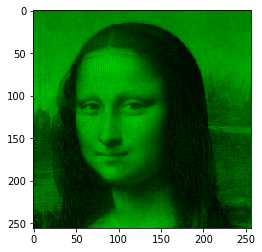

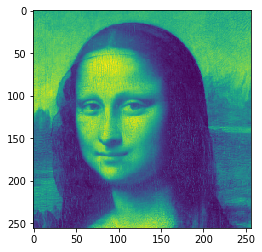

In [20]:
# First, read image:
image = plt.imread("data/standardized_ss.png")


# Re-size image, and remove alpha channel
image_resized = resize(image, (256, 256))[:, :, :3]
green_channel = image_resized[:, :, 1]

# Create empty shape holding it
green_img = np.zeros(image_resized.shape)

# Assign to empty image:
green_img[:,:,1] = green_channel

plt.imshow(green_img)
plt.show()

# But for some odd reason, this doesn't work: but that is because you need 
# all other channels to go to zero for the green channel to show up.
plt.imshow(image_resized[:, :, 1])


In [21]:
# Testing using a color channel to make it clear where I'm applying the blending
# for the X axis
# as you move from the midpoint to the right, 
# take the sigmoid of X to determine how much to blend
bg_image = image_resized
video_frame = predictions_video[0]

# Create a placeholder for the final image
blended_final = np.zeros(bg_image.shape)
xs = np.linspace(0, 256, 256)
alpha = np.array([mirrored_sigmoid(x) for x in xs])

for c in range(3):
    # Since x = 0 where alpha = 0.5; and x = 255 where alpha = 1, this means that towards the beginning
    # when we multiply by alpha, we are weighing less of an image there. So this means that
    # our video frame needs to be multiplied by alpha
    # And our BG image needs to be multiplied by 1 - alpha. Towards the beginning, then, 1 - 0.5
    blended_final[:, :, c] = (video_frame[:, :, c] * alpha) + (green_img[:, :, c] * (1.0 - alpha))
    

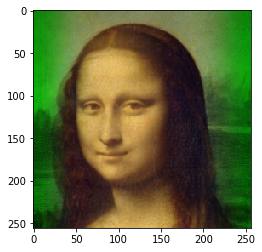

In [22]:
plt.imshow(blended_final)

In [42]:
# Create empty shape holding green image -- this is just to more clearly visualize what is being blended
green_channel = image_resized[:, :, 1]
green_img = np.zeros(image_resized.shape)

# Assign to empty image:
green_img[:,:,1] = green_channel

# Now, for the actual blending. 
# First, create a matrix of alphas which I'll use like a mask.
alpha = np.zeros((256, 256))
for x in range(256):
    for y in range(256):
        # Apply the sigmoid to both X and Y axes
        alpha[x, y] = min(mirrored_sigmoid(x), mirrored_sigmoid(y))

# Intialize where the blended video will go
blended_video = np.zeros(predictions_video.shape)
for i, frame in enumerate(predictions_video):

    # Create a placeholder for the final frame
    blended_frame = np.zeros(image_resized.shape)
    # To visualize what was overlaid
    blended_frame_green = np.zeros(image_resized.shape)
    
    # Blend for all channels
    for c in range(3):
        blended_frame[:, :, c] = (frame[:, :, c] * alpha) + (image_resized[:, :, c] * (1.0 - alpha))
        if i == len(predictions_video) - 1:
            blended_frame_green[:, :, c] = (frame[:, :, c] * alpha) + (green_img[:, :, c] * (1.0 - alpha))
    
    # Now stick it into the final blended video
    blended_video[i, :, :, :] = blended_frame

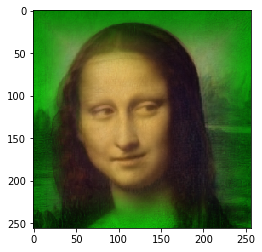

In [43]:
plt.imshow(blended_frame_green)

In [49]:
len(shortened_video)

324

In [46]:
shortened_video = blended_video[222:]

In [ ]:
for i in range(0, len(shortened_video), 10):
    plt.imsave(f"frames/frame_{int(i/10)}.png", shortened_video[i])

## NOW, BLENDING THE BLACK STUCCO BACKGROUND SO THAT THE SEAMS ARE LESS OBVIOUS

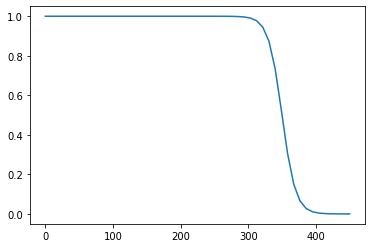

In [56]:
bg_slope = 0.1
bg_inflection = 350


bg_sigmoid = lambda x: 1 / (1 + math.exp(bg_slope * (x - bg_inflection)))

xs = np.linspace(0, 450)
ys = [sigmoid(x) for x in xs]

plt.plot(xs, ys)

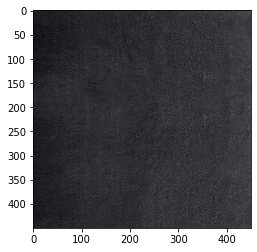

In [26]:
stucco_image = plt.imread("webapp/src/assets/black_stucco.jpg").astype("float32") / 255
plt.imshow(stucco_image)

In [27]:
import skimage

stucco_reversed = skimage.transform.rotate(stucco_image, 180)

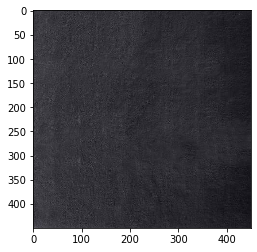

In [28]:
plt.imshow(stucco_reversed)
plt.show()

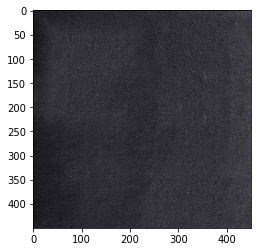

In [61]:

# Create a placeholder for the final image
blended_bg = np.zeros(stucco_image.shape)
xs = np.linspace(0, 450, 450)
alpha_bg = np.zeros((450, 450))
for x in range(450):
    alpha_bg[x] = bg_sigmoid(x)
    
for c in range(3):
    blended_bg[:, :, c] = (stucco_reversed[:, :, c] * alpha) + (stucco_image[:, :, c] * (1.0 - alpha))

plt.imshow(blended_bg)

In [58]:
plt.imsave("blended_black_stucco.jpg", blended_bg)